In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

NUM_CLASSES = 10
NUM_DIM = 2
RANDOM_SEED = 42
NUM_SAMPLES = 2000

x, y = make_blobs(
    n_samples=NUM_SAMPLES,
    n_features=NUM_DIM,
    random_state=RANDOM_SEED,
    centers=NUM_CLASSES,
    shuffle=True,
    cluster_std=1.5,
)

plt.figure(figsize=(12, 12))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="rainbow", s=4)
plt.show()

In [ ]:
import torch

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [ ]:
x.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
from torch import nn


class BlobClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, output_dim),
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.mlp(tensor)


model = BlobClassifierModel(NUM_DIM, NUM_CLASSES, hidden_units=8).to(device)
model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)


def acc_fn(y_pred, y_true):
    equals = torch.eq(y_true, y_pred).sum().item()
    return equals / len(y_true) * 100

In [ ]:
model(x_test.to(device))[:5].shape

In [ ]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000
x_train, x_test, y_train, y_test = x_train.to(device), x_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    train_logits = model(x_train).squeeze()
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(train_logits, y_train)
    train_acc = acc_fn(train_loss, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_preds, y_test)

    if epoch % 10 == 0:
        print(
            f"Epoch:{epoch}, TrainLoss: {train_loss}, TrainAcc:{train_acc}, TestLoss:{test_loss}, TestAcc:{test_acc}"
        )


In [ ]:
from torchmetrics import Accuracy, Precision, Recall

accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES).to(device)
precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES).to(device)

y_pred = model(x_test)

print(
    f"Accuracy: {accuracy_metric(y_pred, y_test)}, Precision: {precision_metric(y_pred, y_test)}, Recall: {recall_metric(y_pred, y_test)}")

In [ ]:

def plot_decision_boundry(model_, x_values, y_values):
    model_ = model_.to("cpu")
    x_values = x_values.to("cpu")
    y_values = y_values.to("cpu")

    x_min, x_max = x_values[:, 0].min() - 0.1, x_values[:, 0].max() + 0.1
    y_max, y_min = x_values[:, 1].max() + 0.1, x_values[:, 1].min() - 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))

    x2pred_on = torch.from_numpy(np.column_stack([xx.ravel(), yy.ravel()])).float()

    with torch.inference_mode():
        y_logits = model_(x2pred_on).squeeze()

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) if len(torch.unique(y_values)) > 2 else torch.round(
        torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="rainbow", alpha=0.7)
    plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, s=40, cmap="rainbow", edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training")
plot_decision_boundry(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing")
plot_decision_boundry(model, x_test, y_test)

* practise

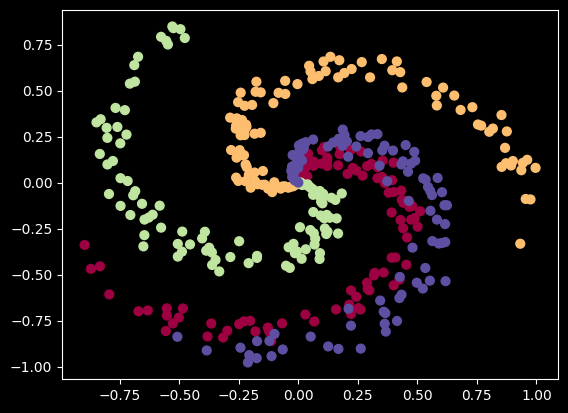

In [49]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
D = 2
K = 4
RANDOM_SEED = 42
x = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2
    x[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [50]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

x.shape, y.shape

(torch.Size([400, 2]), torch.Size([400]))

In [51]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([320, 2]),
 torch.Size([320]),
 torch.Size([80, 2]),
 torch.Size([80]))

In [52]:
from torch import nn

class SpiralModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_features=8):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.Tanh(),
            nn.Linear(hidden_features, out_features)
        )

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        return self.seq(tensor)


model = SpiralModel(D, K).to(device)
model

SpiralModel(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [53]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

def acc_fn(y_esti: torch.Tensor, y_true: torch.Tensor):
    equals = torch.eq(y_esti, y_true).sum().item()
    return equals / len(y_true) * 100


In [54]:
epochs = 1000

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    train_logits = model(x_train).squeeze()
    train_loss = loss_fn(train_logits, y_train)

    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
    train_acc = acc_fn(train_preds, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_loss = loss_fn(test_logits, y_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_acc = acc_fn(test_preds, y_test)

    if epoch % 10 == 0:
        print(
            f"Epoch:{epoch}, TrainLoss: {train_loss}, TrainAcc:{train_acc}, TestLoss:{test_loss}, TestAcc:{test_acc}"
        )



Epoch:0, TrainLoss: 1.381363034248352, TrainAcc:23.4375, TestLoss:1.400508165359497, TestAcc:23.75
Epoch:10, TrainLoss: 1.2760816812515259, TrainAcc:35.3125, TestLoss:1.2985061407089233, TestAcc:28.749999999999996
Epoch:20, TrainLoss: 1.2021147012710571, TrainAcc:40.3125, TestLoss:1.2317062616348267, TestAcc:32.5
Epoch:30, TrainLoss: 1.1455676555633545, TrainAcc:40.0, TestLoss:1.1720459461212158, TestAcc:38.75
Epoch:40, TrainLoss: 1.106334924697876, TrainAcc:39.6875, TestLoss:1.1297448873519897, TestAcc:35.0
Epoch:50, TrainLoss: 1.0830905437469482, TrainAcc:39.6875, TestLoss:1.0979530811309814, TestAcc:36.25
Epoch:60, TrainLoss: 1.0701029300689697, TrainAcc:39.375, TestLoss:1.0772135257720947, TestAcc:38.75
Epoch:70, TrainLoss: 1.0618250370025635, TrainAcc:39.0625, TestLoss:1.0648143291473389, TestAcc:37.5
Epoch:80, TrainLoss: 1.0543135404586792, TrainAcc:40.0, TestLoss:1.0566871166229248, TestAcc:38.75
Epoch:90, TrainLoss: 1.0461912155151367, TrainAcc:40.9375, TestLoss:1.0497566461563

In [55]:
def plot_decision_boundry(model_, x_values, y_values):
    model_ = model_.to("cpu")
    x_values = x_values.to("cpu")
    y_values = y_values.to("cpu")

    x_min, x_max = x_values[:, 0].min() - 0.1, x_values[:, 0].max() + 0.1
    y_max, y_min = x_values[:, 1].max() + 0.1, x_values[:, 1].min() - 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))

    x2pred_on = torch.from_numpy(np.column_stack([xx.ravel(), yy.ravel()])).float()

    with torch.inference_mode():
        y_logits = model_(x2pred_on).squeeze()

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) if len(torch.unique(y_values)) > 2 else torch.round(
        torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="rainbow", alpha=0.7)
    plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, s=40, cmap="rainbow", edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

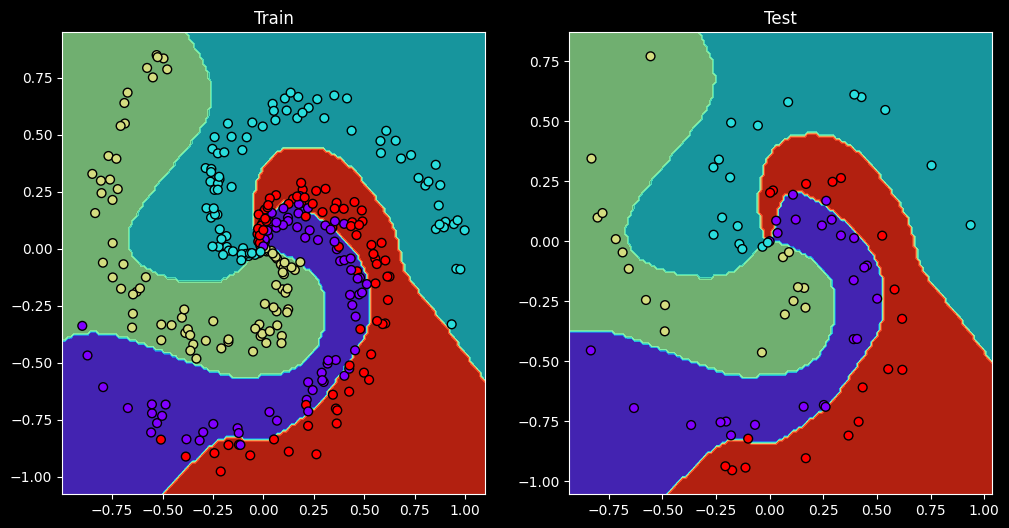

In [56]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundry(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundry(model, x_test, y_test)